In [268]:
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import tensorflow.keras.datasets as datasets
from torch_dataload import MyDataset
import nn_fuzzy
import matplotlib.pyplot as plt
import time
import math

In [269]:
def pi_membership_function(r,c,radius):
    norm = abs(r-c)
    if radius == 0:
        return np.zeros(norm.shape)
    else:
        for i in range(len(r)):
            if norm[i] <= radius and norm[i] >= radius/2:
                norm[i] = (2*((1-norm[i]/radius)**2))
#                 print("Case 1")
            elif norm[i] < radius/2 and norm[i] >= 0:
                norm[i] = (1 - 2*((norm[i]/radius)**2))
#                 print("Case 2")
            else:
                norm[i] = 0
#                 print("Case 3")
    return norm

In [270]:
def input_features(x_train, iid = 1):
    fdenom = 1
    if iid == 1:
        F_max = np.array([255] * x_train.shape[1])
        F_min = np.array([0] * x_train.shape[1])
    else:
        F_max = np.ndarray.max(x_train, axis = 0)
        F_min = np.ndarray.min(x_train, axis = 0)
    lambda_medium = 0.5*(F_max - F_min)
    c_medium = F_min + lambda_medium
#     print(c_medium)
    lambda_low = (1/fdenom)*(c_medium-F_min)
#     print(lambda_low)
    c_low = c_medium - 0.5 * lambda_low
#     print(c_low)
    lambda_high = (1/fdenom) * (F_max - c_medium)
#     print(lambda_high)
    c_high = c_medium + 0.5 * lambda_high
#     print(c_high)
    features = {
        'c_low' : c_low,
        'c_medium' : c_medium,
        'c_high' : c_high,
        'lambda_low' : lambda_low,
        'lambda_medium' : lambda_medium,
        'lambda_high' : lambda_high,
    }
    return features
    

In [271]:
def input_fuzzify(x_train, features, cnn = 0):
    c_low = features['c_low']
    c_medium = features['c_medium']
    c_high = features['c_high']
    lambda_low = features['lambda_low']
    lambda_medium = features['lambda_medium']
    lambda_high = features['lambda_high']
    x_train = x_train.T
    if cnn == 1:
        x_train_low = []
        x_train_medium = []
        x_train_high = []
        for i in range(x_train.shape[0]):
            x_train_low.append(pi_membership_function(x_train[i],c_low[i],lambda_low[i]))
            x_train_medium.append(pi_membership_function(x_train[i],c_medium[i],lambda_medium[i]))
            x_train_high.append(pi_membership_function(x_train[i],c_high[i],lambda_high[i]))
        x_train_new = np.stack([np.array(x_train_low).T, np.array(x_train_medium).T, np.array(x_train_high).T], axis = 1)
        return np.array(x_train_new)
    else:
        x_train_new = []
        for i in range(x_train.shape[0]):
            x_train_new.append(pi_membership_function(x_train[i],c_low[i],lambda_low[i]))
            x_train_new.append(pi_membership_function(x_train[i],c_medium[i],lambda_medium[i]))
            x_train_new.append(pi_membership_function(x_train[i],c_high[i],lambda_high[i]))
        return np.array(x_train_new).T

In [272]:
def getDataset(name, nClass):
    if name=="mnist":
        dataset = datasets.mnist
    (x_train, y_train),(x_test, y_test) = dataset.load_data()     #downloading and loading the dataset
    x_train, x_test = x_train, x_test            #normalizing the input data
    x_train_flat = x_train.reshape(x_train.shape[0],-1)         #making dataset suitable for input in Fully Connected layer
    x_test_flat = x_test.reshape(x_test.shape[0],-1)          #making dataset suitable for input in Fully Connected layer
    y_train_onehot = np.eye(nClass)[y_train]                    #converting to one hot vectors
    y_test_onehot = np.eye(nClass)[y_test]                     #converting to one hot vectors
    print(x_train_flat.shape)
    print(y_train_onehot.shape)
    x_train_batch = np.array_split(x_train_flat, int(60000/128))
    print(x_train_batch[2].shape)
    return x_train_flat,x_test_flat,y_train_onehot,y_test_onehot

x_train, x_test, y_train, y_test = getDataset("mnist", 10)

(60000, 784)
(60000, 10)
(129, 784)


In [273]:
features = input_features(x_train)

In [282]:
x_train_fuzzy = input_fuzzify(x_train, features, cnn =1)

In [283]:
x_train_fuzzy.shape

(60000, 3, 784)

In [284]:
x_train_fuzzy = x_train_fuzzy.reshape(-1, 3, 28, 28)

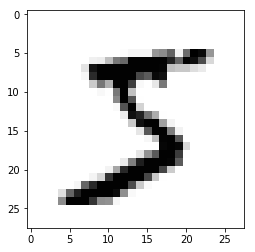

In [285]:
index = 0
plt.imshow(x_train[index].reshape(28,28), cmap='Greys')

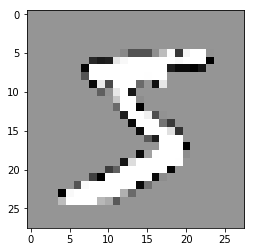

In [286]:
plt.imshow(x_train_fuzzy[index][0], cmap='Greys')

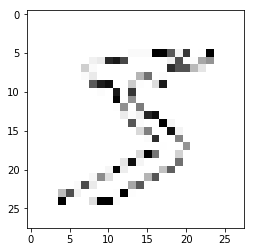

In [287]:
plt.imshow(x_train_fuzzy[index][1].reshape(28,28), cmap='Greys')

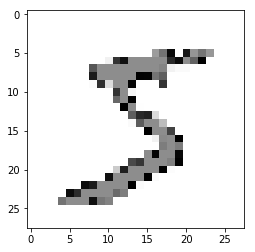

In [288]:
plt.imshow(x_train_fuzzy[index][2].reshape(28,28), cmap='Greys')

In [289]:
np.save('x_train_fuzzy', x_train_fuzzy)

In [290]:
x_test_fuzzy = input_fuzzify(x_test, features, cnn =1)

In [291]:
np.save('x_test_fuzzy', x_test_fuzzy)

In [199]:
pi_membership_function(r,c_low[0], lambda_low[0])

array([5.00000000e-01, 5.15563245e-01, 5.30880431e-01, 5.45951557e-01,
       5.60776624e-01, 5.75355632e-01, 5.89688581e-01, 6.03775471e-01,
       6.17616301e-01, 6.31211073e-01, 6.44559785e-01, 6.57662438e-01,
       6.70519031e-01, 6.83129566e-01, 6.95494041e-01, 7.07612457e-01,
       7.19484814e-01, 7.31111111e-01, 7.42491349e-01, 7.53625529e-01,
       7.64513649e-01, 7.75155709e-01, 7.85551711e-01, 7.95701653e-01,
       8.05605536e-01, 8.15263360e-01, 8.24675125e-01, 8.33840830e-01,
       8.42760477e-01, 8.51434064e-01, 8.59861592e-01, 8.68043060e-01,
       8.75978470e-01, 8.83667820e-01, 8.91111111e-01, 8.98308343e-01,
       9.05259516e-01, 9.11964629e-01, 9.18423683e-01, 9.24636678e-01,
       9.30603614e-01, 9.36324491e-01, 9.41799308e-01, 9.47028066e-01,
       9.52010765e-01, 9.56747405e-01, 9.61237985e-01, 9.65482507e-01,
       9.69480969e-01, 9.73233372e-01, 9.76739715e-01, 9.80000000e-01,
       9.83014225e-01, 9.85782391e-01, 9.88304498e-01, 9.90580546e-01,
      

In [159]:
pi_membership_function(r, c_medium[0], lambda_medium[0])

array([0.37216455])

In [200]:
pi_membership_function(r, c_high[0], lambda_high[0])

array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
      

In [234]:
x_train.shape

(60000, 784)

In [195]:
test = x_train[0:2]

In [191]:
test = test.reshape(-1,28,28)

In [196]:
print(test.shape)
print(test.astype(int))


(2, 784)
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [247]:
low = []
medium = []
high = []
for i in x_train[0:100].T:
    print(i.shape)
    low.append(pi_membership_function(i, c_low[0], lambda_low[0]))

(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)
(100,)

In [236]:
low = np.array(low)

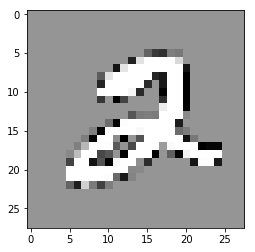

In [237]:
plt.imshow(low.T.reshape(-1,28,28)[5], cmap='Greys')

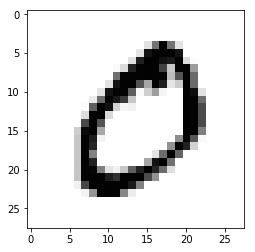

In [183]:
plt.imshow(test.reshape(28,28), cmap = 'Greys')

In [201]:
for i in test.T:
    print(i)

[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[ 0 51]
[  0 159]
[  0 253]
[  0 159]
[ 0 50]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[0 0]
[3 0]
[18  0]
[18 48]
[ 18 238]
[126 252]
[136 252]
[175 252]
[ 26 237]


In [232]:
x_train.T.shape

(784, 60000)

In [233]:
test.T.shape

(784, 2)